In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.impute import SimpleImputer, KNNImputer
import math

# Loading Dataset and EDA

In [2]:
filename = "data/speeddating.csv"

data = pd.read_csv(filename, sep=',', low_memory=False)

data.head()


,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0,1,female,21,27,6,[4-6],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,6,[6-8],[5-6],0,1,0,0
1,0,1,female,21,22,1,[0-1],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,5,[6-8],[5-6],1,1,0,0
2,1,1,female,21,22,1,[0-1],'Asian/Pacific Islander/Asian-American','Asian/Pacific Islander/Asian-American',1,...,[0-3],[3-5],7,?,[6-8],[0-4],1,1,1,1
3,0,1,female,21,23,2,[2-3],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7,6,[6-8],[5-6],0,1,1,1
4,0,1,female,21,24,3,[2-3],'Asian/Pacific Islander/Asian-American','Latino/Hispanic American',0,...,[0-3],[3-5],6,6,[6-8],[5-6],0,1,1,1


In [3]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 123 entries, has_null to match
dtypes: int64(7), object(116)
memory usage: 7.9+ MB


**Data removing justification**

Looking at our data, we see that we have a large number of columns (123). This is a warning for us because there can be some columns which are highly correlated or explain similar information and these are not beneficial for out study. Moreover, there can be some columns which we already know it won’t affect much the target variable. Hence, we are going to analyze the columns and decide which should stay and which no. 

In [4]:
print(data.columns.tolist())

['has_null', 'wave', 'gender', 'age', 'age_o', 'd_age', 'd_d_age', 'race', 'race_o', 'samerace', 'importance_same_race', 'importance_same_religion', 'd_importance_same_race', 'd_importance_same_religion', 'field', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'd_pref_o_attractive', 'd_pref_o_sincere', 'd_pref_o_intelligence', 'd_pref_o_funny', 'd_pref_o_ambitious', 'd_pref_o_shared_interests', 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o', 'd_attractive_o', 'd_sinsere_o', 'd_intelligence_o', 'd_funny_o', 'd_ambitous_o', 'd_shared_interests_o', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'd_attractive_important', 'd_sincere_important', 'd_intellicence_important', 'd_funny_important', 'd_ambtition_important', 'd_shared_interests_important', 'attractive', 'sincere', '

On the one hand, there are some informative columns which don’t affect the target variable but explain some information of the date. We are going to remove these columns because are noise to our study. Those columns are: wave, position, position_o, pid, iid, id, partner, pid_o, round, has_null.

On the other hand, we have found out that there are some columns which talk about the same information and are redundant. We should remove this columns as well to avoid multicolinearity and simplify the study. Tese columns are all the collumns which have d_ at the beginning. These columns talk about the difference betwen columns.: d_age is the difference in ages, d_attractive is the difference betwen attractivness ratings, … We consider a better option to stay with the individual columns (for example age and age_o) instead of using the difference (d_age) because those columns explain more information and the difference column is inherent in the others (our network can interpret this relation). This happens with all the difference columns, so we have decided to remove them all.

In [46]:
# List of columns to delete
cols_to_drop = [
    'wave', 'position', 'position_o', 'pid', 'iid', 'id', 'partner', 'pid_o',
    'round', 'has_null', 'samerace', 'd_age', 'd_field', 'd_race',
    'd_importance_same_race', 'd_importance_same_religion',
    'd_pref_o_attractive', 'd_pref_o_sincere', 'd_pref_o_intelligence',
    'd_pref_o_funny', 'd_pref_o_ambitious', 'd_pref_o_shared_interests',
    'd_attractive_o', 'd_sinsere_o', 'd_intelligence_o', 'd_funny_o',
    'd_ambitous_o', 'd_shared_interests_o', 'd_attractive_important',
    'd_sincere_important', 'd_intellicence_important', 'd_funny_important',
    'd_ambtition_important', 'd_shared_interests_important', 'd_attractive',
    'd_sincere', 'd_intelligence', 'd_funny', 'd_ambition',
    'd_attractive_partner', 'd_sincere_partner', 'd_intelligence_partner',
    'd_funny_partner', 'd_ambition_partner', 'd_shared_interests_partner',
    'd_sports', 'd_tvsports', 'd_exercise', 'd_dining', 'd_museums', 'd_art',
    'd_hiking', 'd_gaming', 'd_clubbing', 'd_reading', 'd_tv', 'd_theater',
    'd_movies', 'd_concerts', 'd_music', 'd_shopping', 'd_yoga',
    'd_interests_correlate', 'd_expected_happy_with_sd_people',
    'd_expected_num_interested_in_me', 'd_expected_num_matches',
    'd_like', 'd_guess_prob_liked', 'decision', 'decision_o', 'met'
]

data = data.drop(columns=cols_to_drop, errors='ignore')

print(f"Number of remaining columns: {data.shape[1]}")

Number of remaining columns: 57


In [6]:
# List of columns to delete
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   gender                         8378 non-null   object
 1   age                            8378 non-null   object
 2   age_o                          8378 non-null   object
 3   d_d_age                        8378 non-null   object
 4   race                           8378 non-null   object
 5   race_o                         8378 non-null   object
 6   importance_same_race           8378 non-null   object
 7   importance_same_religion       8378 non-null   object
 8   field                          8378 non-null   object
 9   pref_o_attractive              8378 non-null   object
 10  pref_o_sincere                 8378 non-null   object
 11  pref_o_intelligence            8378 non-null   object
 12  pref_o_funny                   8378 non-null   object
 13  pre

### Object Problem

As we can see, there is some problem with our data that we have to adress. There are some columns that we see that have numeric values but are detected as object. This is caused because there are some ‘?’ that indicate that someone does not know something. For example, if there is ‘?’ on a rating variable, it means that the participant (or the other) does not know how to rate the other person in that specific attribute. For this reason, we are going to adress this values as NaN, in order to treat that variables as numeric as they are.

In [7]:
## Nominal atributes
obj_cols = data.select_dtypes(include='object').columns

for col in obj_cols:
    print(col, data[col].unique()[:15])

gender ['female' 'male']
age ['21' '24' '25' '23' '22' '26' '27' '30' '28' '?' '29' '34' '35' '32' '39']
age_o ['27' '22' '23' '24' '25' '30' '28' '21' '26' '29' '?' '39' '32' '34' '35']
d_d_age ['[4-6]' '[0-1]' '[2-3]' '[7-37]']
race ["'Asian/Pacific Islander/Asian-American'" 'European/Caucasian-American'
 'Other' "'Latino/Hispanic American'" "'Black/African American'" '?']
race_o ['European/Caucasian-American' "'Asian/Pacific Islander/Asian-American'"
 "'Latino/Hispanic American'" 'Other' "'Black/African American'" '?']
importance_same_race ['2' '8' '1' '4' '7' '3' '9' '10' '?' '5' '6' '0']
importance_same_religion ['4' '5' '1' '3' '2' '8' '10' '6' '?' '7' '9']
field ['Law' 'law' 'Economics' "'Masters in Public Administration'"
 "'Masters of Social Work&Education'" 'Finance' 'Business'
 "'political science'" 'money' "'Operations Research'" "'TC [Health Ed]'"
 'Psychology' "'social work'" "'Social Work'"
 "'Speech Language Pathology'"]
pref_o_attractive ['35' '60' '19' '30' '50' '33.3

In [8]:
data.replace('?', pd.NA, inplace=True)

In [9]:
print(data.columns.tolist())

['gender', 'age', 'age_o', 'd_d_age', 'race', 'race_o', 'importance_same_race', 'importance_same_religion', 'field', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambition_partner', 'shared_interests_partner', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'interests_correlate', 'expected_happy_with_sd_people', 'expected_num_interested_in_me', 'expected_num_matches', 'like', 'guess_prob_liked', 'met', 'match']

In [10]:
## Data that is actually Nominal
cols_nom = ['gender', 'race', 'race_o', 'field', 'match']
## Data that is actually Numeric            
cols_num = ['age', 'age_o', 'd_d_age', 'importance_same_race', 'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere', 
            'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_important', 'sincere_important', 
            'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'attractive', 'sincere', 
            'intelligence', 'funny', 'ambition', 'attractive_partner', 'shared_interests_partner', 'sports', 'tvsports', 'exercise',
            'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 
            'shopping', 'yoga', 'interests_correlate', 'expected_happy_with_sd_people', 'expected_num_interested_in_me', 'expected_num_matches',
            'like', 'guess_prob_liked', 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o' , 'sincere_partner',
            'intelligence_partner', 'ambition_partner', 'funny_partner'
           ]       

In [11]:
## Explicitly coversion using the API documentation
for col in cols_num:
    if col in data.columns:  
        data[col] = pd.to_numeric(data[col], errors='coerce')
for col in cols_nom:
    if col in data.columns:
        data[col] = data[col].astype('category')

In [12]:
## We can check the correct atributes!!
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   gender                         8378 non-null   category
 1   age                            8283 non-null   float64 
 2   age_o                          8274 non-null   float64 
 3   d_d_age                        0 non-null      float64 
 4   race                           8315 non-null   category
 5   race_o                         8305 non-null   category
 6   importance_same_race           8299 non-null   float64 
 7   importance_same_religion       8299 non-null   float64 
 8   field                          8315 non-null   category
 9   pref_o_attractive              8289 non-null   float64 
 10  pref_o_sincere                 8289 non-null   float64 
 11  pref_o_intelligence            8289 non-null   float64 
 12  pref_o_funny                   828

In [13]:
## Nulls
data.shape[0] - data.dropna().shape[0]

8378

In [14]:
null_counts = data.isnull().sum()

null_counts_with_values = null_counts[null_counts != 0]

print(null_counts_with_values)

age                                95
age_o                             104
d_d_age                          8378
race                               63
race_o                             73
                                 ... 
expected_num_interested_in_me    6578
expected_num_matches             1173
like                              240
guess_prob_liked                  309
met                               375
Length: 61, dtype: int64


**Missing values**

Once we have solved the problem with ‘?’ values, now we have to adress missing values. As we can see, we have a lot of columns with missing value. However, we have columns with more missing values than other, and this is crucial to decide how we are going to treat them. As there are variables with a high percentatge of missing values, wr have decided to put a treshold of percentatge of missing values. So, our procedure with missing values is the following:

- Get rid of columns with > 10% of missing values
- Impute missing values of columns with < 10% missing values.

We consider that those columns with 10% of missing values are not useful to out study because are unclear variables or variables with incomplete information. For this reason, we do not find woth it to impute them values, as the imputation would be imprecise and we would add noise to our dataset. Talking about the other columns, we dont’t consider to eliminate rows with missing values because there are a lot of attributes, and it does not make sense to us to get rid of a row only because it has a NaN in one specific column and not in the others.

In [15]:
## Searching for columns to delete or impute
threshold = 0.1  # 10%
cols_to_drop = data.columns[data.isnull().mean() > threshold]
cols_to_impute = data.columns[data.isnull().mean() <= threshold]

## Deleting data
data = data.drop(columns=cols_to_drop)
## Imputing data
num_cols_to_impute = [col for col in cols_num if col in cols_to_impute]
cat_cols_to_impute = [col for col in cols_nom if col in cols_to_impute]

# Numeric → mediana
imputer_num = SimpleImputer(strategy='median')
data[num_cols_to_impute] = imputer_num.fit_transform(data[num_cols_to_impute])

# Categorical -> mode
imputer_cat = SimpleImputer(strategy='most_frequent')
data[cat_cols_to_impute] = imputer_cat.fit_transform(data[cat_cols_to_impute])

print(f"Remaining columns: {data.shape[1]}")

Remaining columns: 58


In [16]:
## We check if everything is okay with Nulls.
data.shape[0] - data.dropna().shape[0]

0

### Simple Descriptive Analisis

In [17]:
data.describe()

,age,age_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,...,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,like,guess_prob_liked,met
count,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,...,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000
mean,26.354858,26.360468,3.777393,3.645500,22.468839,17.407205,20.267883,17.466034,10.676622,11.827362,...,7.920387,6.827047,7.852471,5.634758,4.335999,0.196274,5.539747,6.130246,5.199869,0.047625
std,3.546684,3.541689,2.833273,2.792688,12.505468,7.007194,6.746824,6.050104,6.087777,6.315311,...,1.692906,2.146157,1.783416,2.596826,2.704966,0.300669,1.724324,1.814855,2.090285,0.275972
min,18.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,-0.830000,1.000000,0.000000,0.000000,0.000000
25%,24.000000,24.000000,1.000000,1.000000,15.000000,15.000000,17.650000,15.000000,5.000000,10.000000,...,7.000000,5.000000,7.000000,4.000000,2.000000,-0.010000,5.000000,5.000000,4.000000,0.000000
50%,26.000000,26.000000,3.000000,3.000000,20.000000,18.370000,20.000000,18.000000,10.000000,10.640000,...,8.000000,7.000000,8.000000,6.000000,4.000000,0.210000,6.000000,6.000000,5.000000,0.000000
75%,28.000000,28.000000,6.000000,6.000000,25.000000,20.000000,23.260000,20.000000,15.000000,15.690000,...,9.000000,8.000000,9.000000,8.000000,6.000000,0.430000,7.000000,7.000000,7.000000,0.000000
max,55.000000,55.000000,10.000000,10.000000,100.000000,60.000000,50.000000,50.000000,53.000000,30.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,0.910000,10.000000,10.000000,10.000000,8.000000


In [18]:
## Duplicates
duplicates = data.duplicated()
print(data[duplicates])

Empty DataFrame
Columns: [gender, age, age_o, race, race_o, importance_same_race, importance_same_religion, field, pref_o_attractive, pref_o_sincere, pref_o_intelligence, pref_o_funny, pref_o_ambitious, pref_o_shared_interests, attractive_o, sinsere_o, intelligence_o, funny_o, ambitous_o, attractive_important, sincere_important, intellicence_important, funny_important, ambtition_important, shared_interests_important, attractive, sincere, intelligence, funny, ambition, attractive_partner, sincere_partner, intelligence_partner, funny_partner, ambition_partner, sports, tvsports, exercise, dining, museums, art, hiking, gaming, clubbing, reading, tv, theater, movies, concerts, music, shopping, yoga, interests_correlate, expected_happy_with_sd_people, like, guess_prob_liked, met, match]
Index: []

[0 rows x 58 columns]


**Outliers**

Now we are going to adress the outliers. Outliers are a threat to out srudy because they don’t represent the data itself. Outliers can affect a lot our results by making our model work on data which does not represent the reality. By adressing them, we are looking not to have those extrem (but coherent) values and stay with the normal ones. But, what are the normal ones? We are going to use IQR method to detect them, I.e, detect as outliers those values above or below certain tresholds depending on Q1 (25th percentile) and Q3. (75th percentile). By the time we have detected the outliers, we are going to base us on the percentatge of outliers again to decide what to do with them. Our criteria this time is the following:

Eliminate outliers from columns with < 1% outliers
Impute ouliers from columns with > 1% outliers

To do the imputation, we have decided to use knn with 5 neighbours, in order to change the value to a more normal one based on his neighbours (those rows more similar to it).

In [19]:
outlier_info = {}

numeric_cols = data.select_dtypes(include=['number']).columns
df_numeric = data[numeric_cols].copy()

for col in numeric_cols:
    Q1 = df_numeric[col].quantile(0.25)
    Q3 = df_numeric[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    outlier_mask = (df_numeric[col] < lower_limit) | (df_numeric[col] > upper_limit)
    num_outliers = outlier_mask.sum()
    perc_outliers = num_outliers / len(df_numeric) * 100

    outlier_info[col] = perc_outliers

outlier_summary = pd.DataFrame.from_dict(outlier_info, orient='index', columns=['%_outliers'])
print("Percentage of outliers by column")
print(outlier_summary.sort_values('%_outliers', ascending=False))

low_outlier_cols = [col for col, perc in outlier_info.items() if perc < 1]
high_outlier_cols = [col for col, perc in outlier_info.items() if perc >= 1]

print(f"\nColumns with <1% outliers: {low_outlier_cols}")
print(f"Columns with >=1% outliers: {high_outlier_cols}")


initial_rows = len(data)

# Remove rows with low-outlier columns
for col in low_outlier_cols:
    Q1 = df_numeric[col].quantile(0.25)
    Q3 = df_numeric[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    data = data[~((data[col] < lower_limit) | (data[col] > upper_limit))]

total_rows_removed = initial_rows - len(data)

# Track total values to impute
total_values_to_impute = 0
for col in high_outlier_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    values_to_impute = ((data[col] < lower_limit) | (data[col] > upper_limit)).sum()
    total_values_to_impute += values_to_impute
    data.loc[(data[col] < lower_limit) | (data[col] > upper_limit), col] = np.nan

print(f"\nTotal rows removed due to low-percentage outliers: {total_rows_removed}")
print(f"Total values to impute (high-percentage outliers): {total_values_to_impute}")

# Apply KNN Imputer only to numeric columns
imputer = KNNImputer(n_neighbors=5)
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])
print("KNN imputation completed for numeric columns.")

Percentage of outliers by column
                               %_outliers
intelligence_partner            18.954404
intelligence_o                  18.930532
sincere_important               13.965147
pref_o_sincere                  13.953211
pref_o_shared_interests         11.231798
shared_interests_important      11.231798
sincere                          9.656243
funny_important                  8.761041
pref_o_funny                     8.749105
attractive_important             6.552877
pref_o_attractive                6.529005
intellicence_important           6.302220
pref_o_intelligence              6.302220
reading                          5.586059
met                              4.285032
funny                            3.688231
ambition                         2.948198
movies                           2.315588
museums                          2.196228
intelligence                     2.100740
age_o                            2.064932
age                              2.064932
d

**Fixing Data**

In [31]:
data.head(10)

,gender,age,age_o,race,race_o,importance_same_race,importance_same_religion,field,pref_o_attractive,pref_o_sincere,...,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,like,guess_prob_liked,met,match
0,female,21.0,27.0,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,2.0,4.0,Law,35.000,20.000,...,10.0,9.0,8.0,1.0,0.14,3.0,7.0,6.0,0.0,0
1,female,21.0,22.0,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,2.0,4.0,Law,32.666,15.984,...,10.0,9.0,8.0,1.0,0.54,3.0,7.0,5.0,0.0,0
2,female,21.0,22.0,'Asian/Pacific Islander/Asian-American','Asian/Pacific Islander/Asian-American',2.0,4.0,Law,19.000,18.000,...,10.0,9.0,8.0,1.0,0.16,3.0,7.0,5.0,0.0,1
3,female,21.0,23.0,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,2.0,4.0,Law,30.000,19.478,...,10.0,9.0,8.0,1.0,0.61,3.0,7.0,6.0,0.0,1
4,female,21.0,24.0,'Asian/Pacific Islander/Asian-American','Latino/Hispanic American',2.0,4.0,Law,30.000,10.000,...,10.0,9.0,8.0,1.0,0.21,3.0,6.0,6.0,0.0,1
5,female,21.0,25.0,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,2.0,4.0,Law,26.000,16.000,...,10.0,9.0,8.0,1.0,0.25,3.0,6.0,5.0,0.0,0
6,female,21.0,30.0,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,2.0,4.0,Law,35.000,15.000,...,10.0,9.0,8.0,1.0,0.34,3.0,6.0,5.0,0.0,0
7,female,21.0,27.0,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,2.0,4.0,Law,33.330,11.110,...,10.0,9.0,8.0,1.0,0.50,3.0,6.0,7.0,0.0,0
8,female,21.0,28.0,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,2.0,4.0,Law,28.000,13.000,...,10.0,9.0,8.0,1.0,0.28,3.0,7.0,7.0,0.0,1
9,female,21.0,24.0,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,2.0,4.0,Law,32.666,15.984,...,10.0,9.0,8.0,1.0,-0.36,3.0,6.0,6.0,0.0,0


In [38]:
data['field'] = data['field'].str.replace("'", "", regex=False).str.title()

## Veryfing Field
print(data['field'].unique()[:20])

['Law' 'Economics' 'Masters In Public Administration'
 'Masters Of Social Work&Education' 'Finance' 'Business'
 'Political Science' 'Money' 'Operations Research' 'Tc [Health Ed]'
 'Psychology' 'Social Work' 'Speech Language Pathology'
 'Speech Languahe Pathology' 'Educational Psychology'
 'Applied Maths/Econs' 'Mathematics' 'Statistics'
 'Organizational Psychology' 'Mechanical Engineering']


In [63]:
data = data.rename(columns={'sinsere_o': 'sincere_o'})
data = data.rename(columns={'ambitous_o': 'ambition_o'})

### Median

In [51]:
numeric_cols = data.select_dtypes(include=['number']).columns

data[numeric_cols].mean()

age                              26.131432
age_o                            26.133285
importance_same_race              3.797806
importance_same_religion          3.641073
pref_o_attractive                20.400959
pref_o_sincere                   17.506420
pref_o_intelligence              20.062735
pref_o_funny                     17.196174
pref_o_ambitious                 10.618262
pref_o_shared_interests          12.502941
attractive_o                      6.202913
sinsere_o                         7.250408
intelligence_o                    7.477831
funny_o                           6.445094
ambitous_o                        6.890835
attractive_important             20.420182
sincere_important                17.495662
intellicence_important           20.015959
funny_important                  17.162672
ambtition_important              10.652194
shared_interests_important       12.507749
attractive                        7.096039
sincere                           8.582620
intelligenc

### Mode

In [52]:
data[numeric_cols].mode()

,age,age_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,...,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,like,guess_prob_liked
0,27.0,27.0,1.0,1.0,20.0,20.0,20.0,20.0,10.0,10.0,...,7.0,8.0,7.0,10.0,7.0,1.0,0.21,6.0,6.0,5.0


In [70]:
## Data By Type
categorical_cols = [col for col in data.columns if data[col].dtype == 'object' and col != 'field']
numerical_cols =  [col for col in data.columns if data[col].dtype == 'float64']

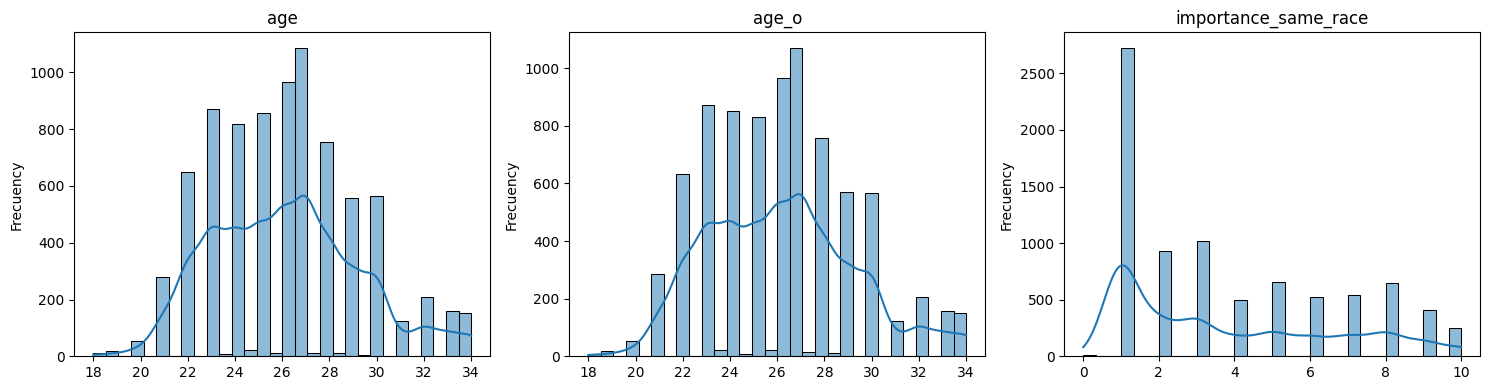

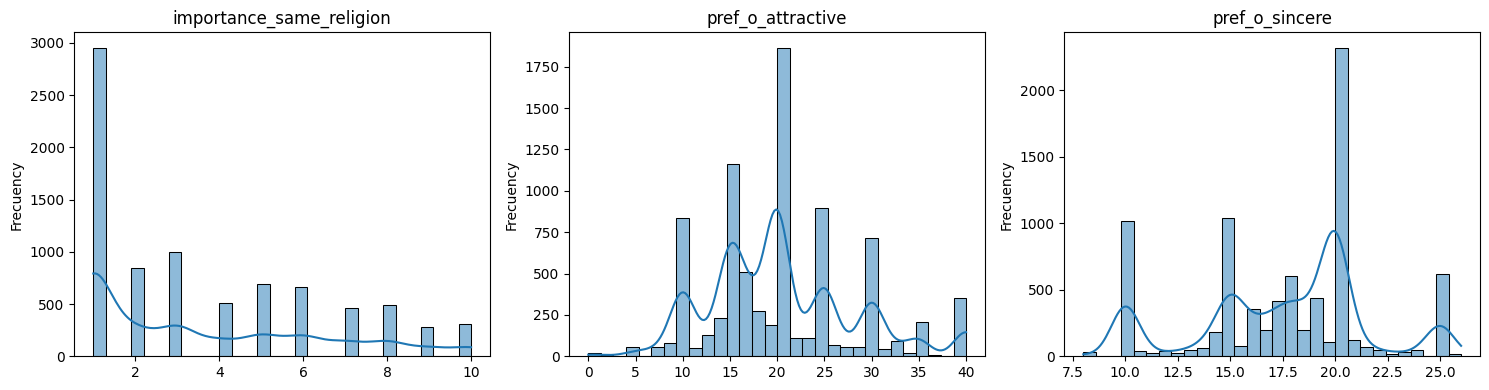

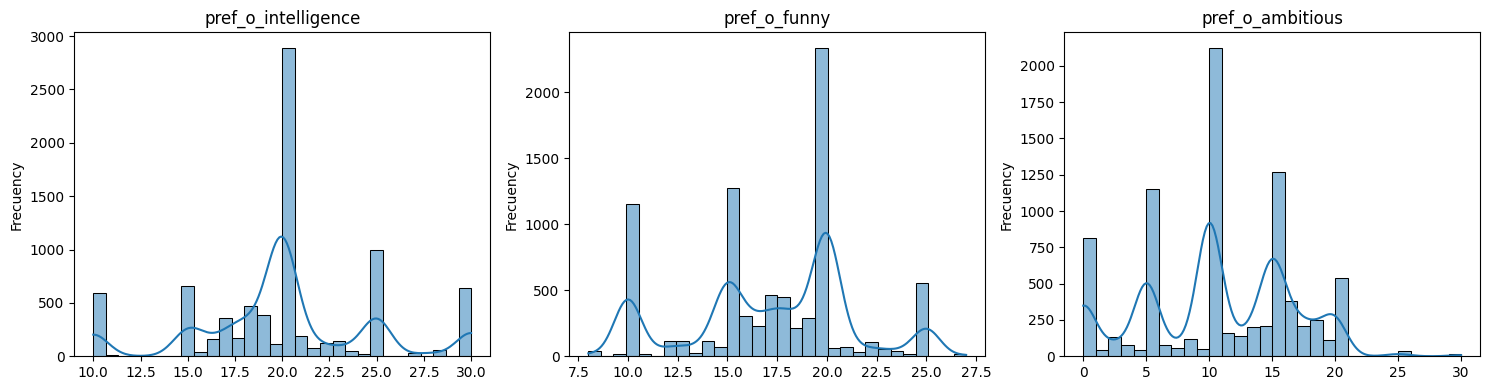

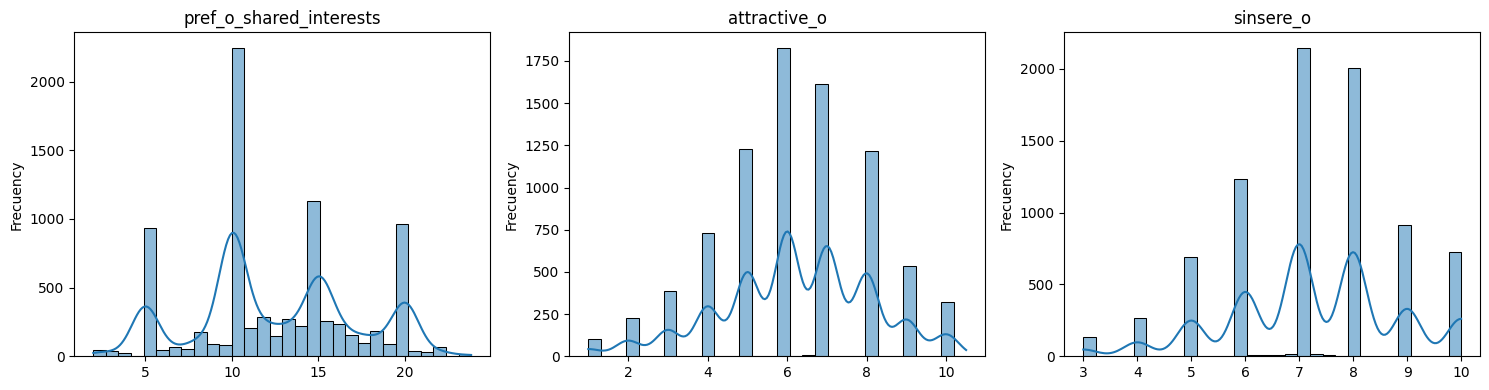

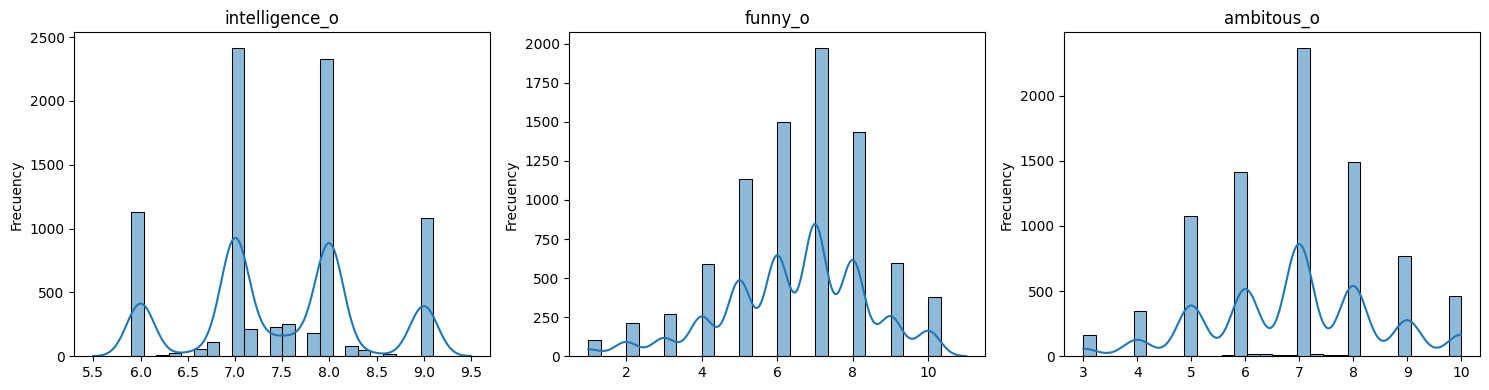

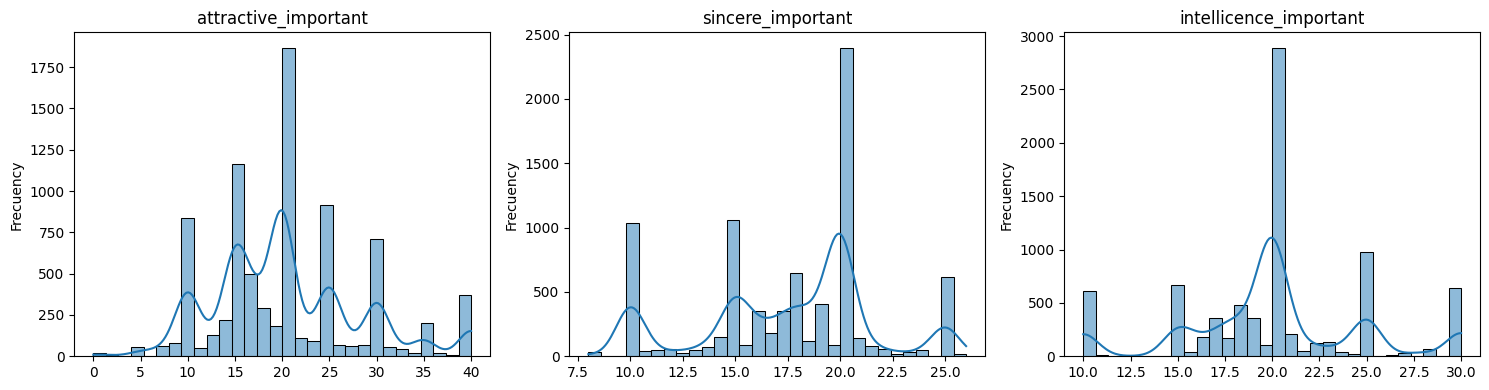

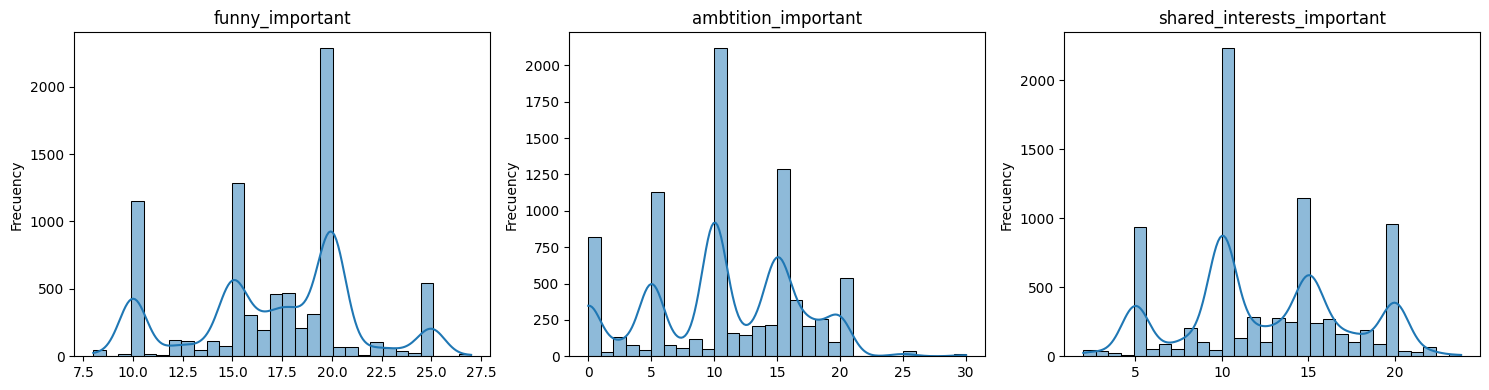

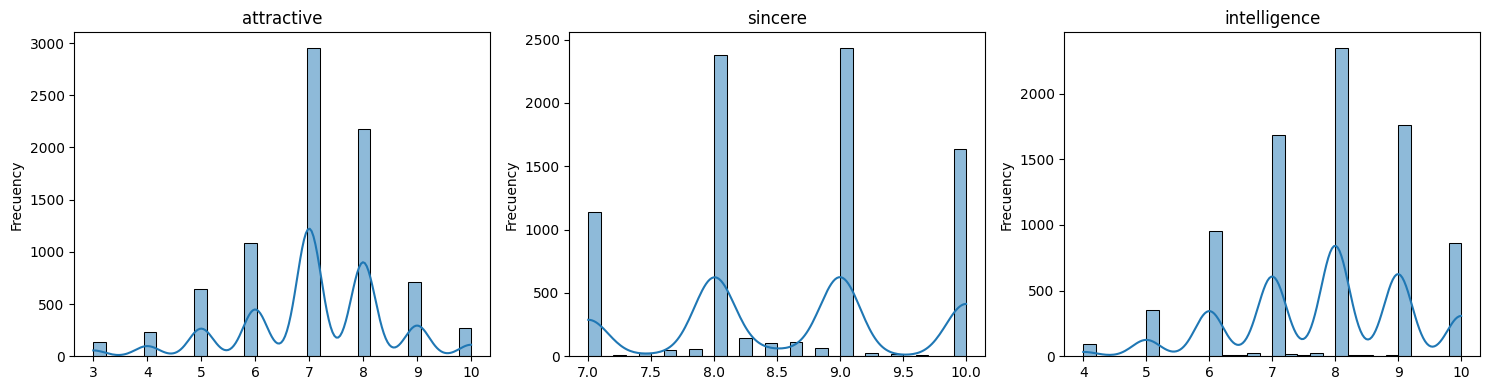

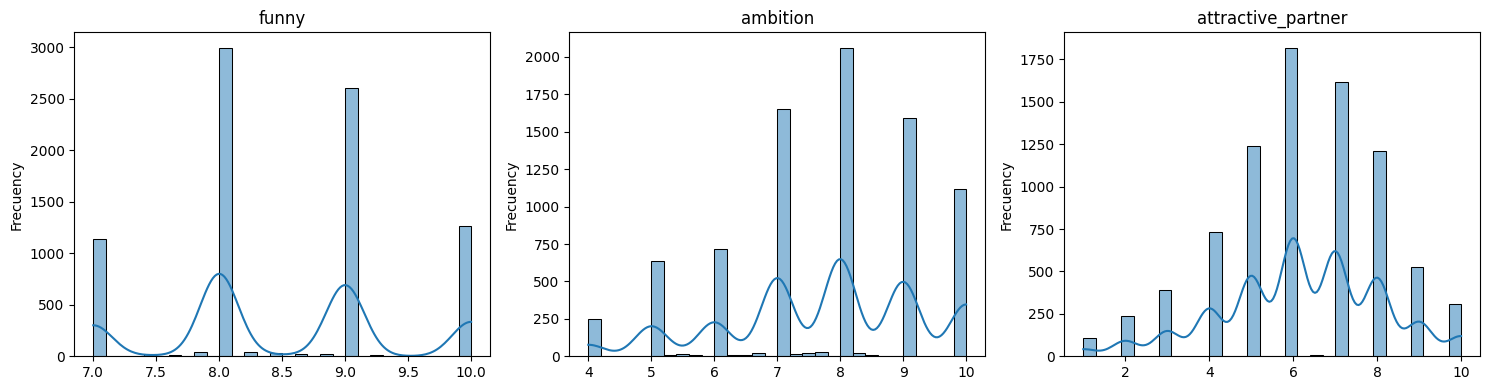

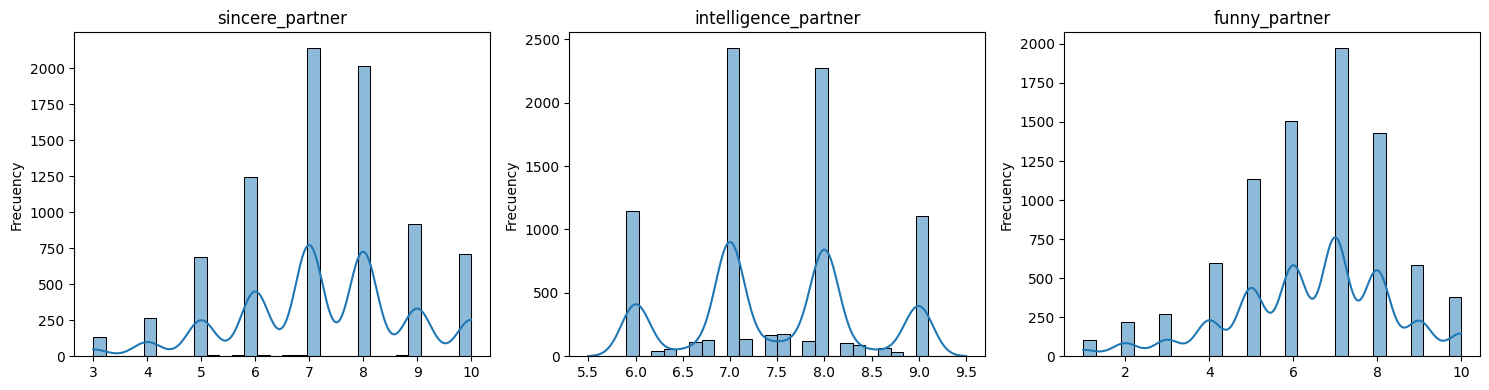

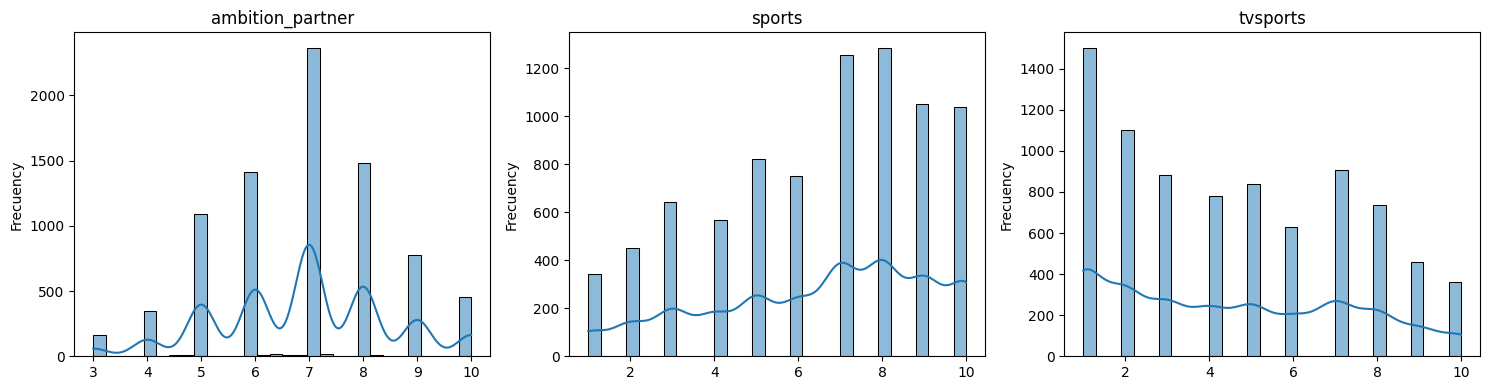

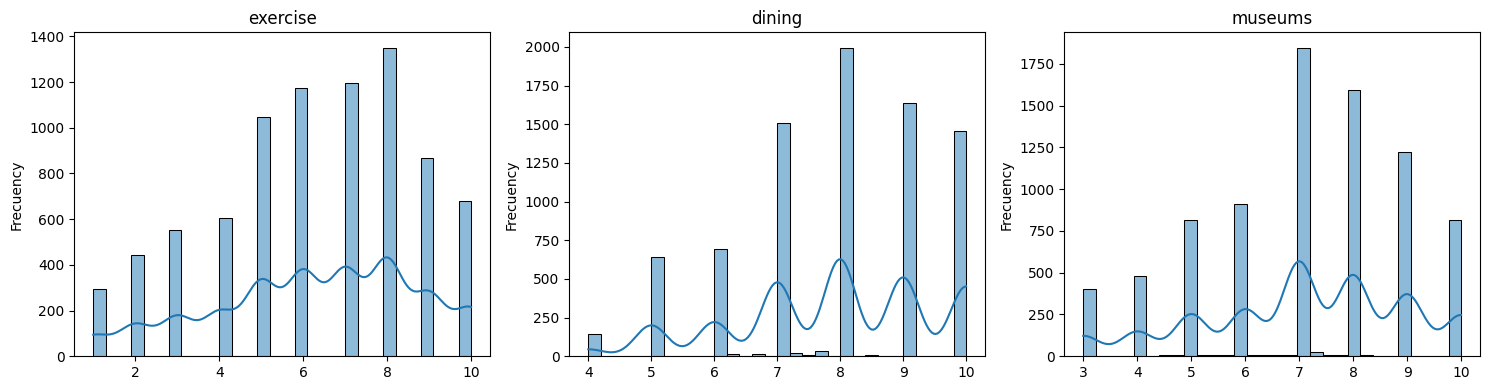

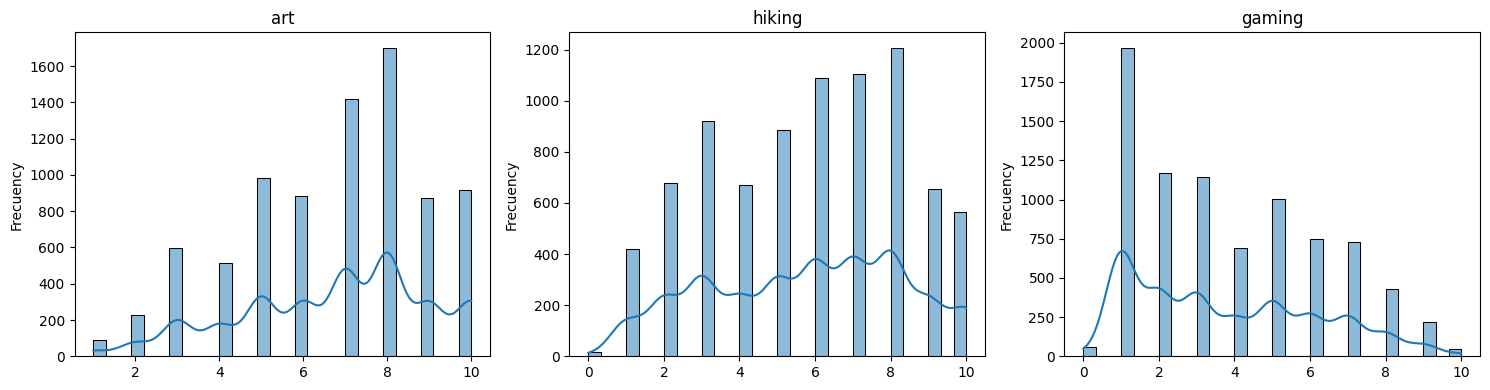

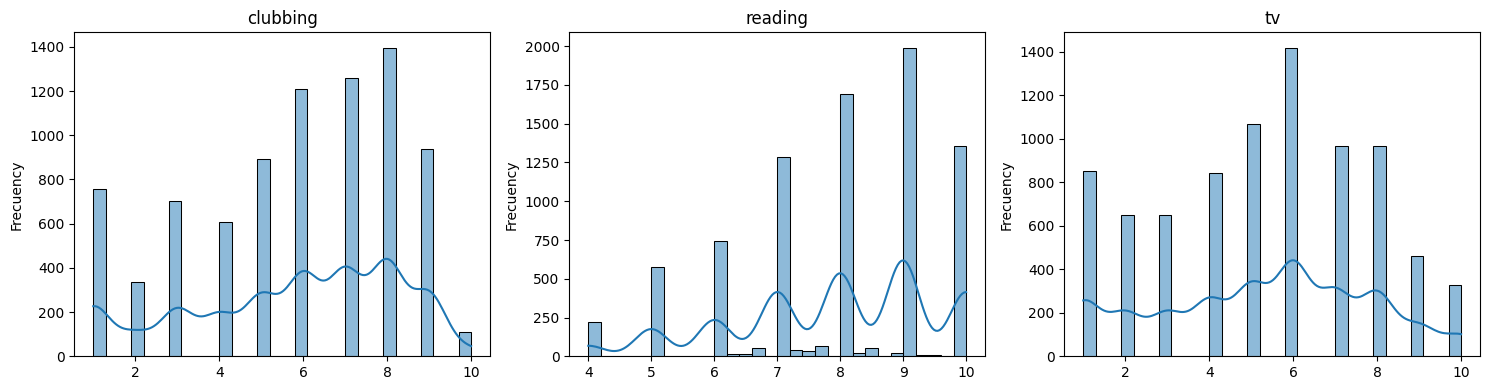

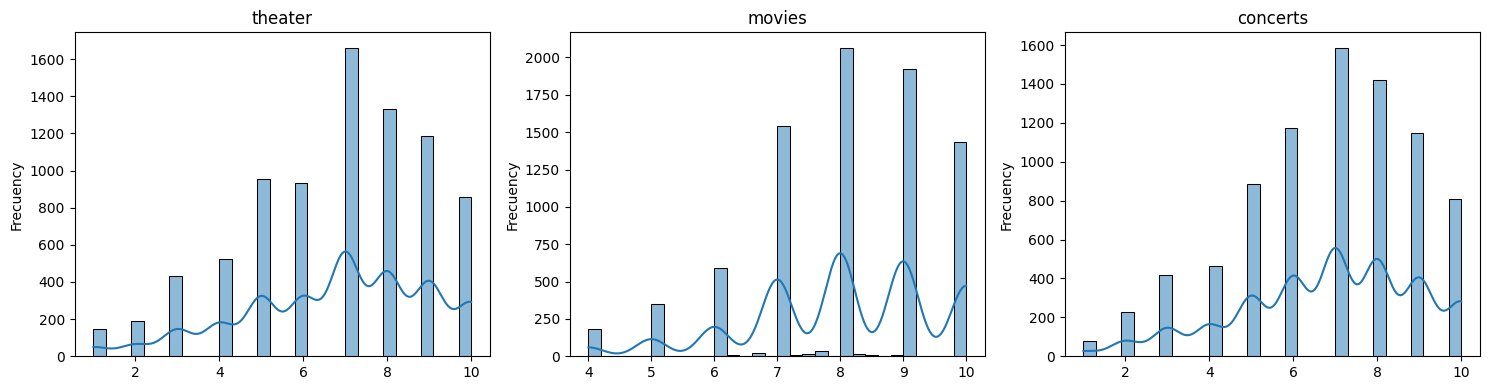

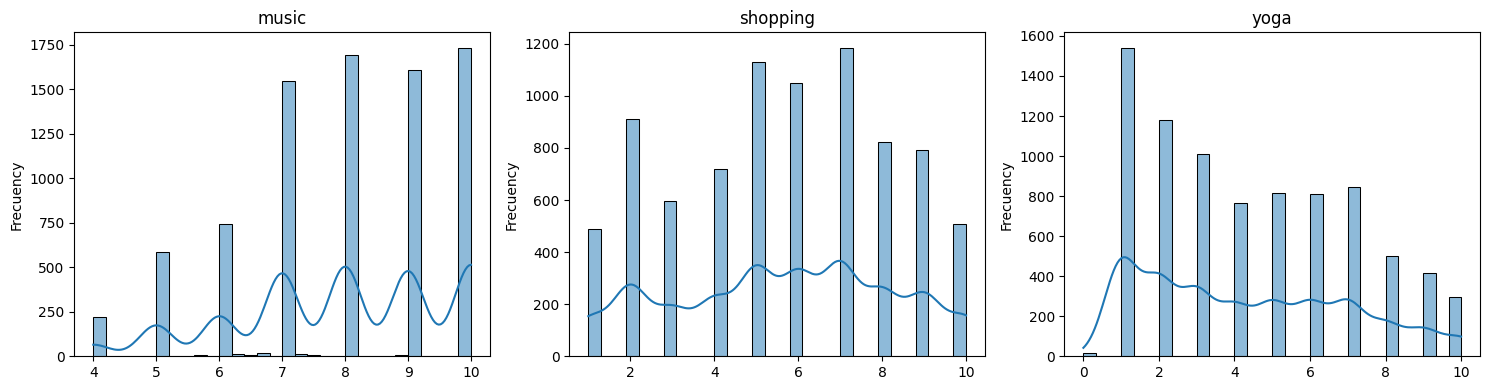

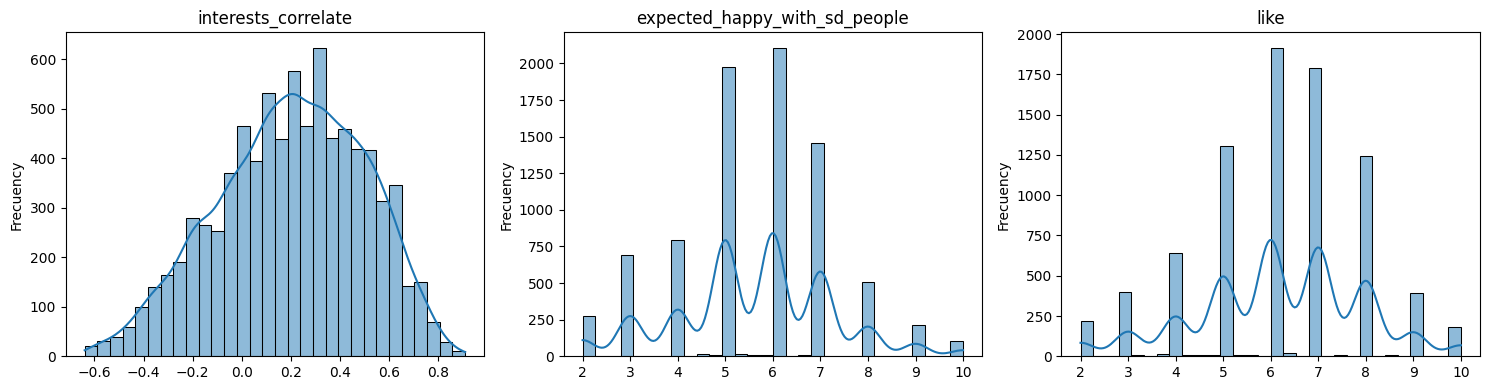

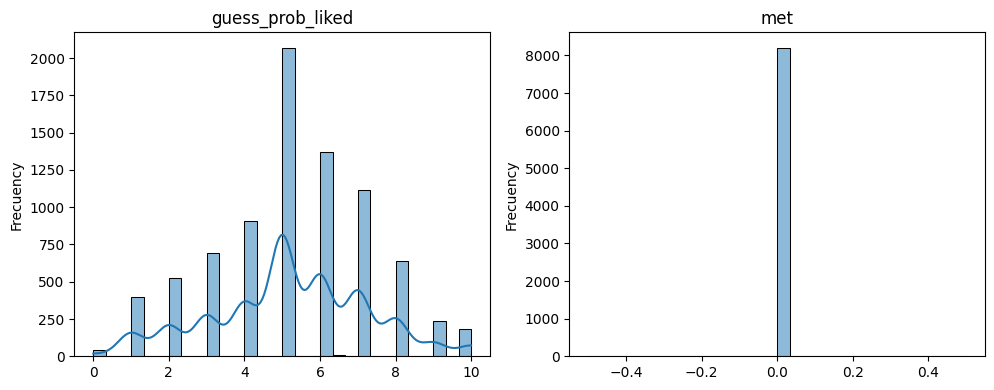

In [45]:
# Histplots to see the distribution
n_per_row = 3
n_rows = math.ceil(len(numeric_cols) / n_per_row)

for r in range(n_rows):
    plt.figure(figsize=(n_per_row*5, 4))
    
    row_cols = numeric_cols[r*n_per_row : (r+1)*n_per_row]
    
    for i, col in enumerate(row_cols, start=1):
        plt.subplot(1, n_per_row, i)
        sns.histplot(data[col], kde=True, bins=30)
        plt.title(col)
        plt.xlabel("")
        plt.ylabel("Frecuency")
    plt.tight_layout()
    plt.show()

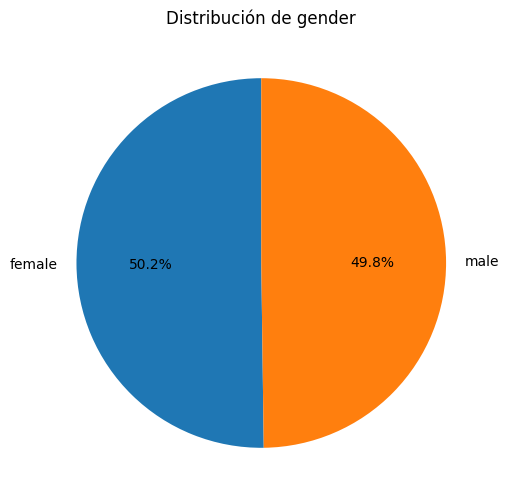

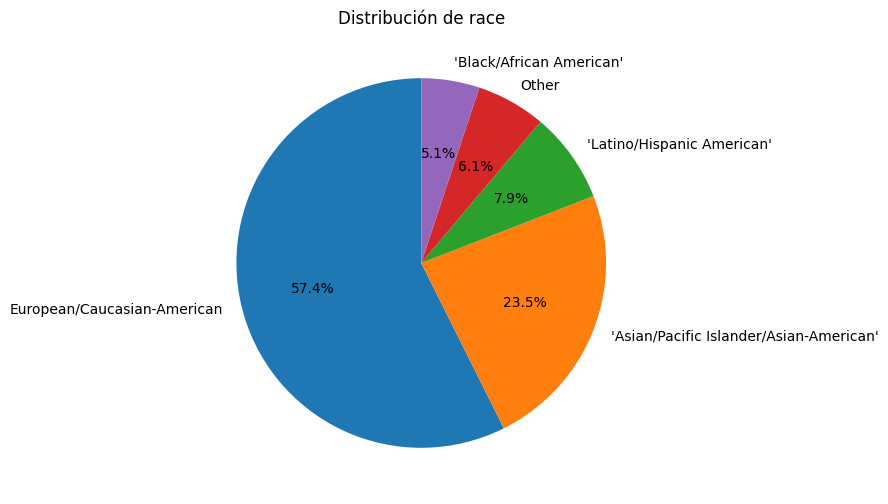

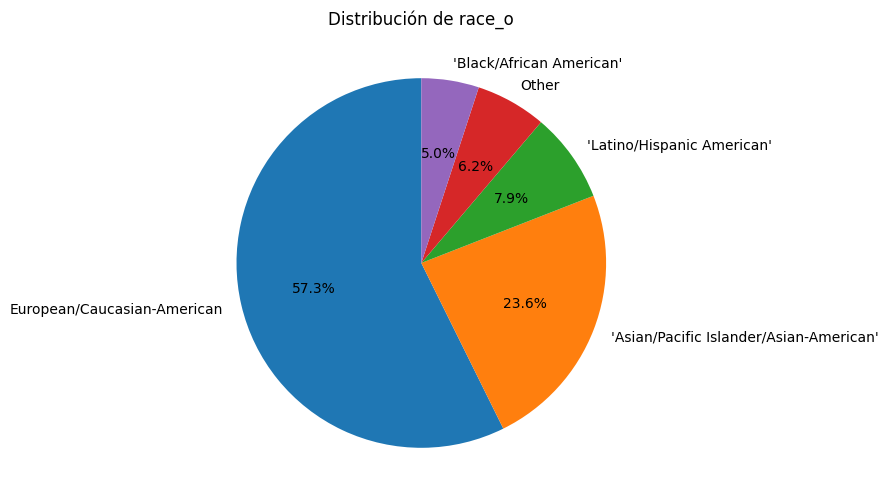

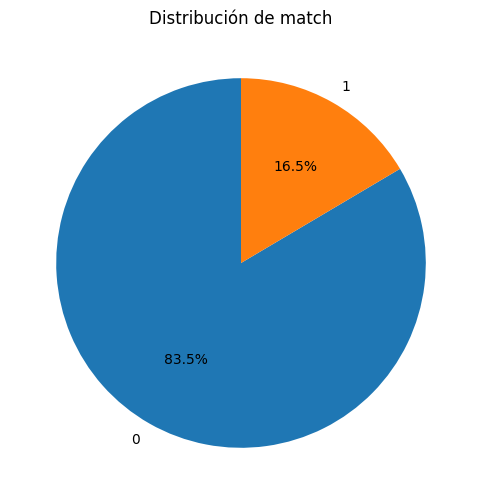

In [54]:
categorical_cols = [col for col in data.columns if data[col].dtype == 'object' and col != 'field']

for col in categorical_cols:
    plt.figure(figsize=(6,6))
    data[col].value_counts().plot(
        kind='pie', autopct='%1.1f%%', startangle=90
    )
    plt.title(f'Distribución de {col}')
    plt.ylabel('')  
    plt.show()


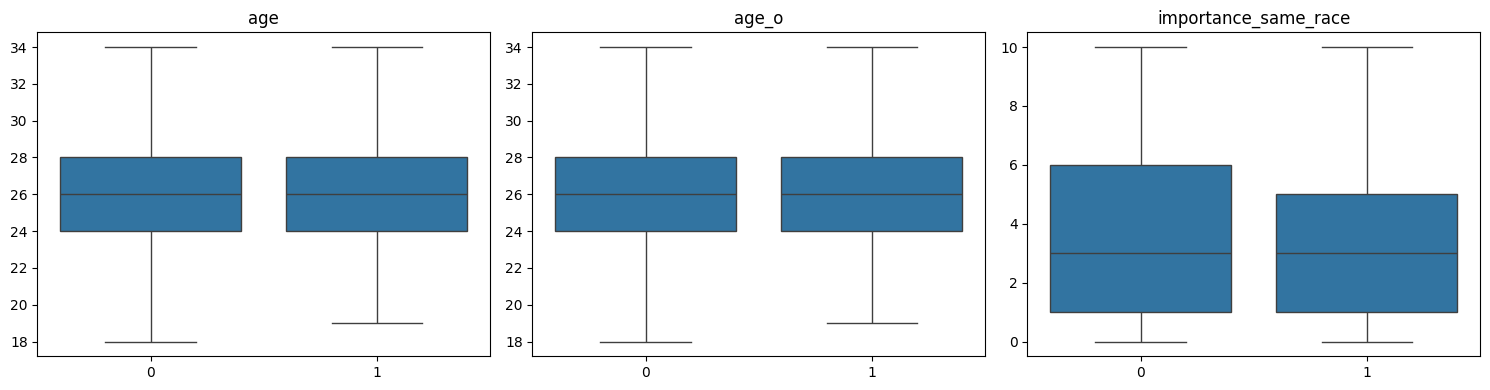

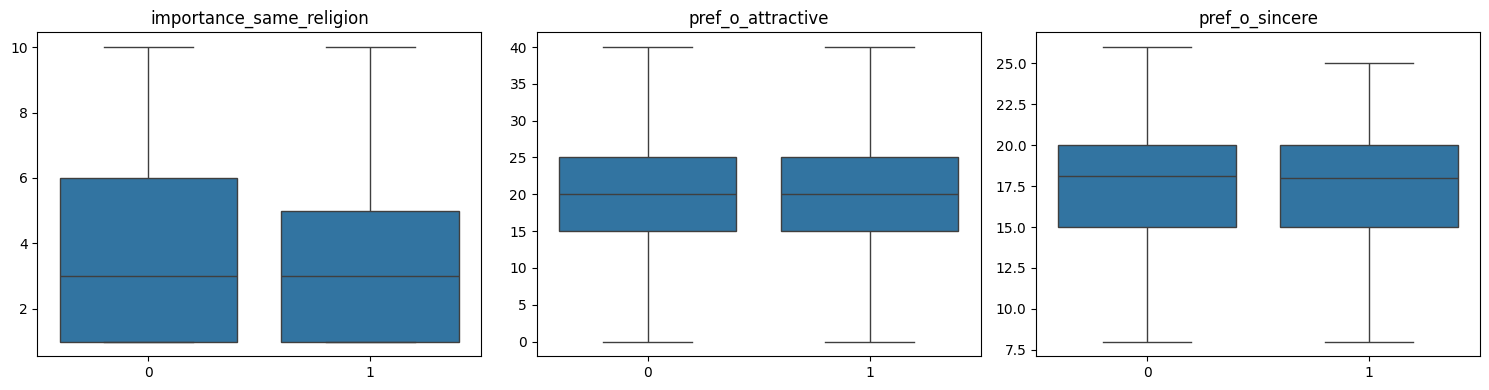

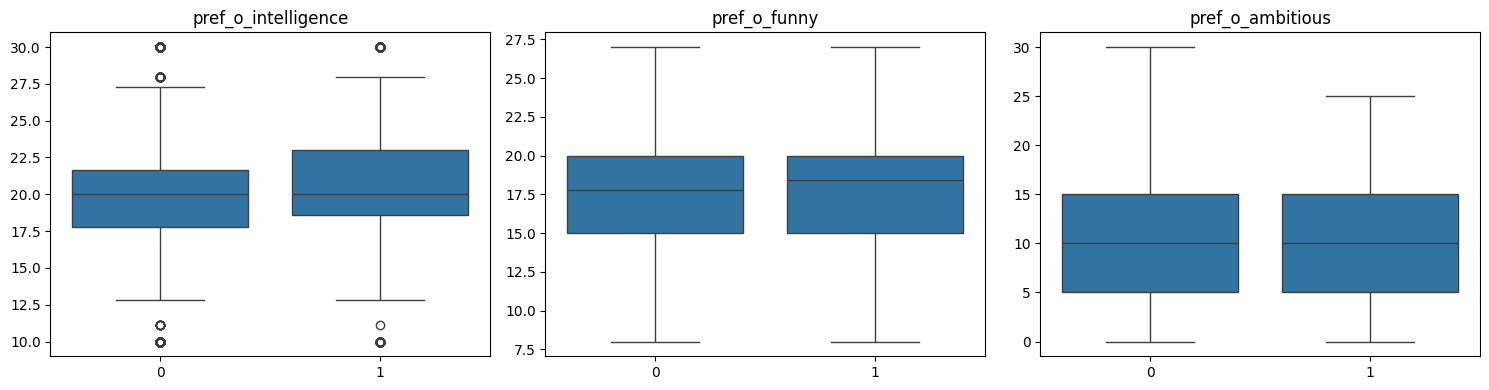

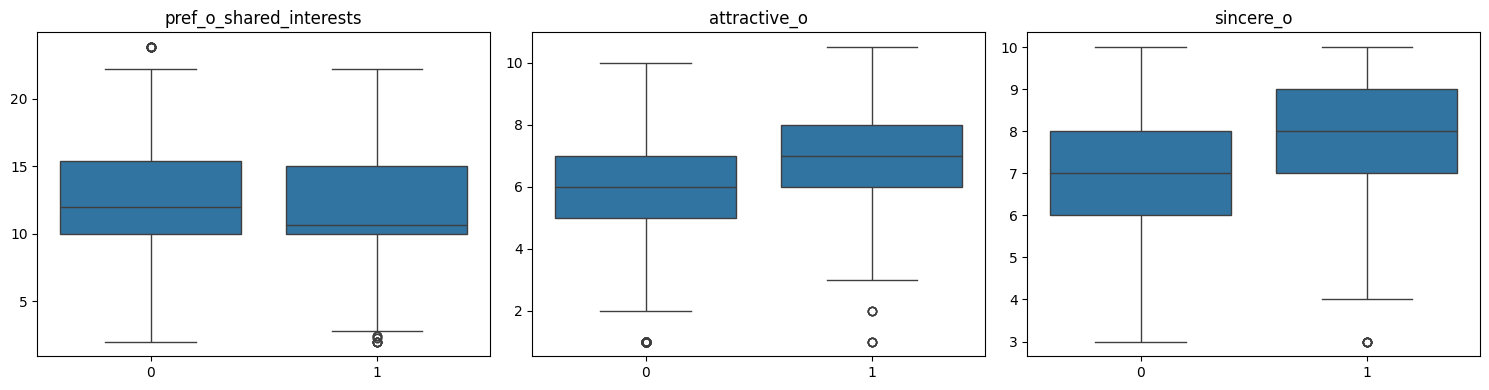

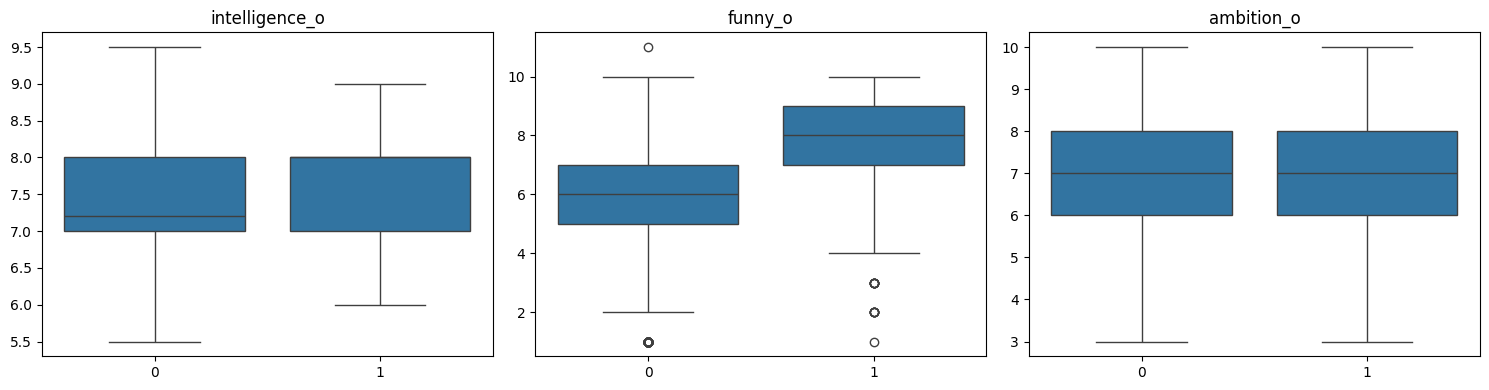

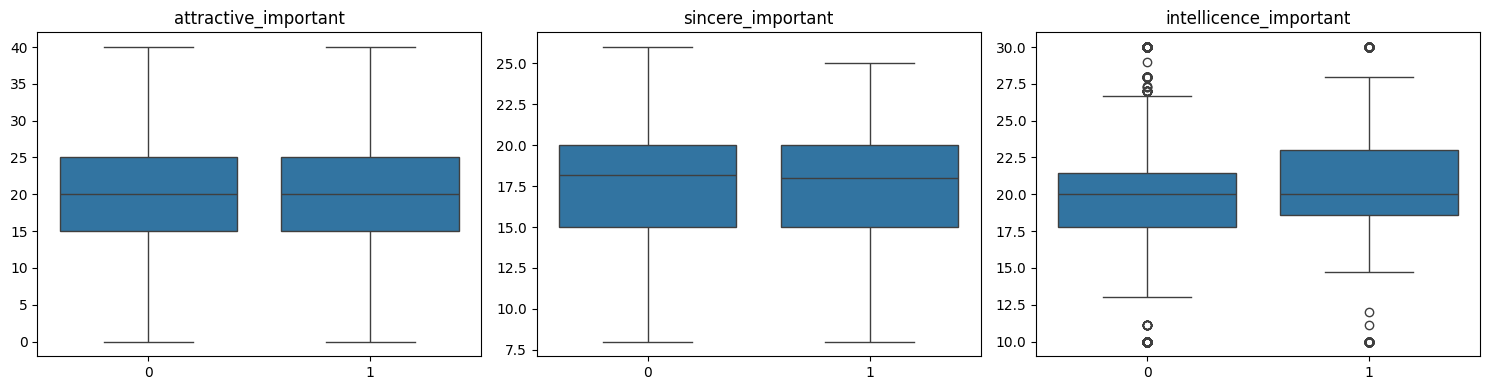

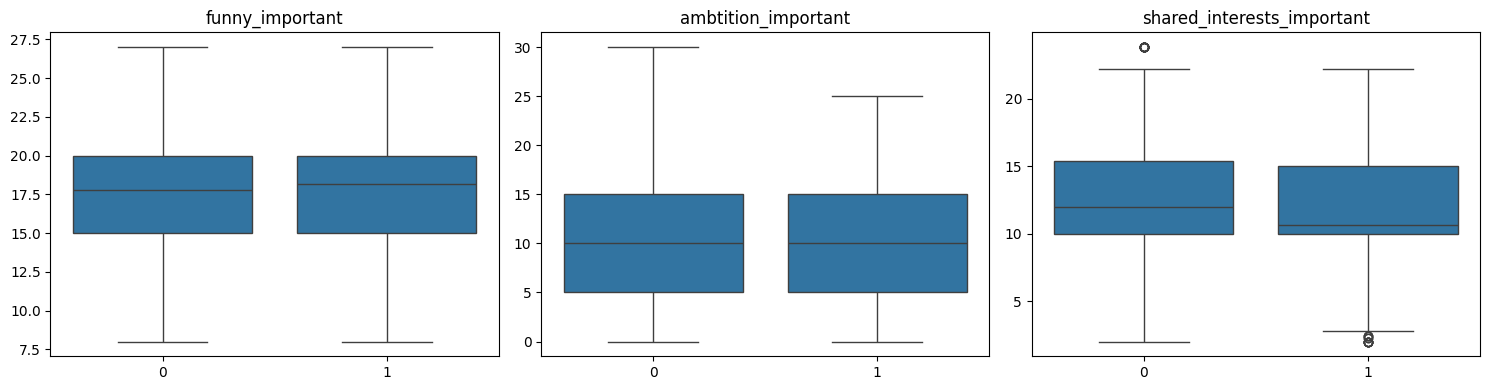

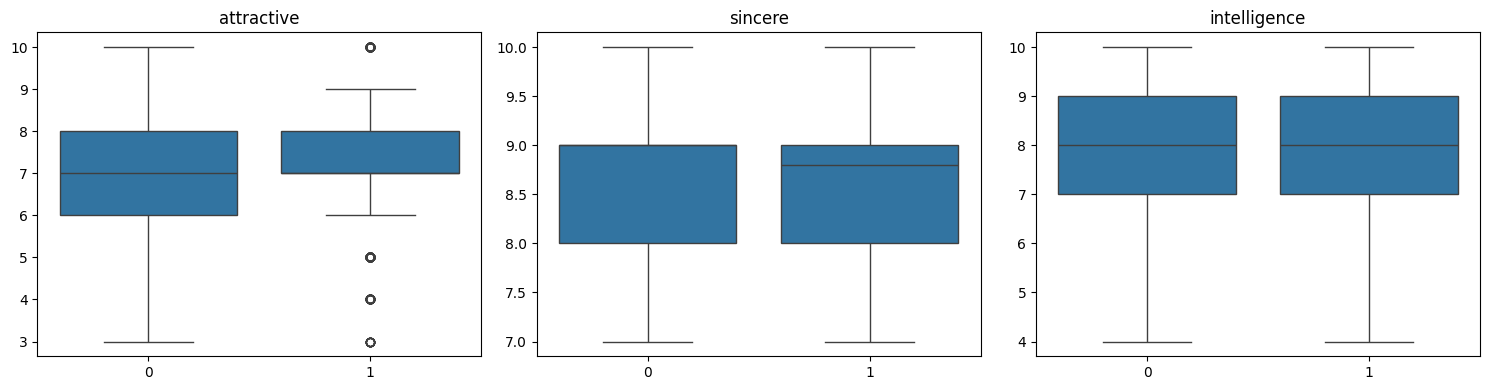

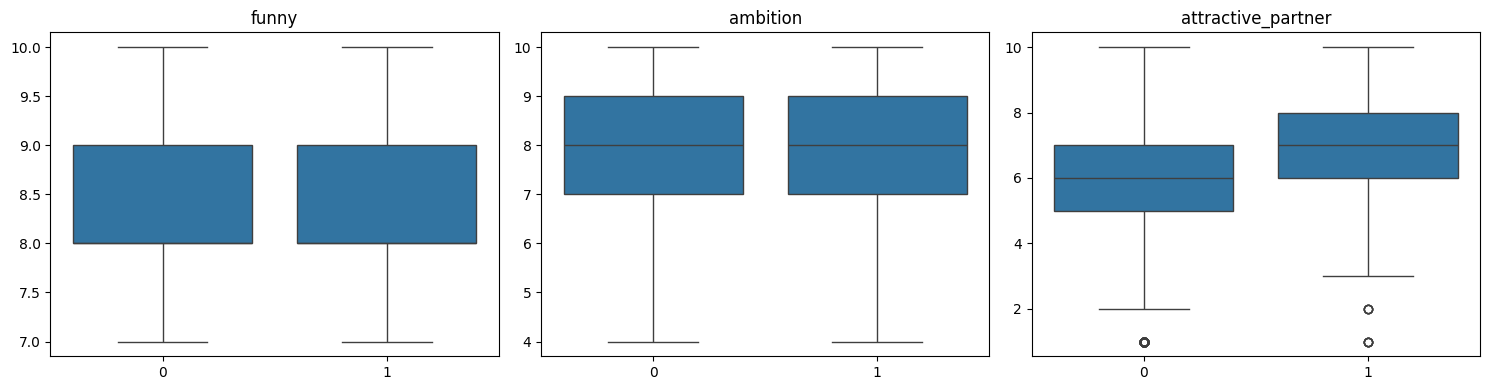

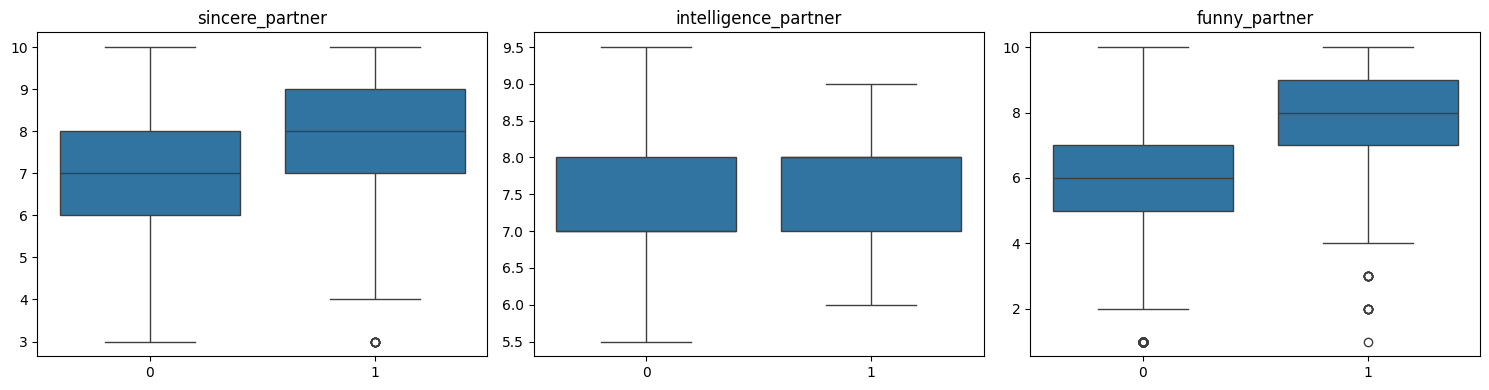

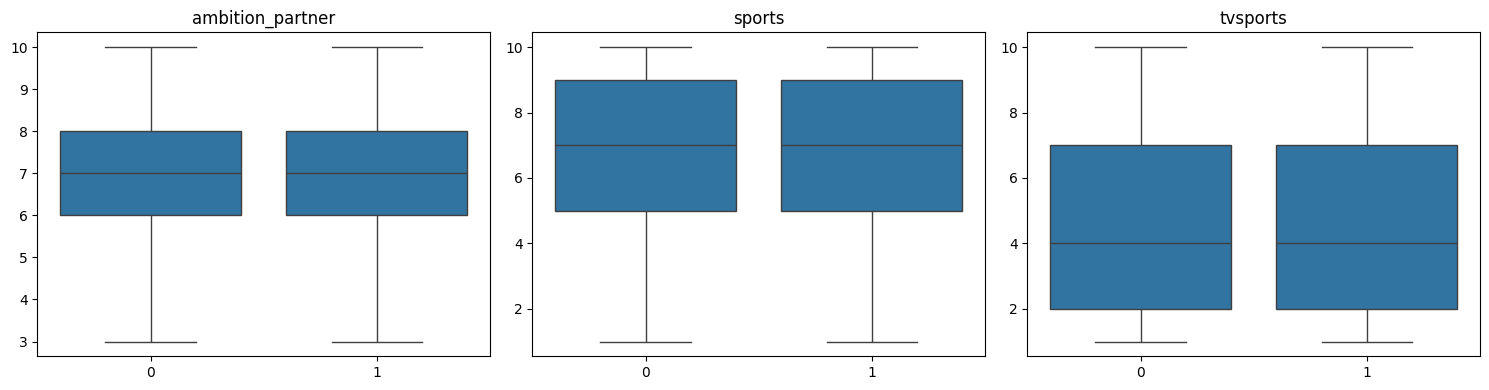

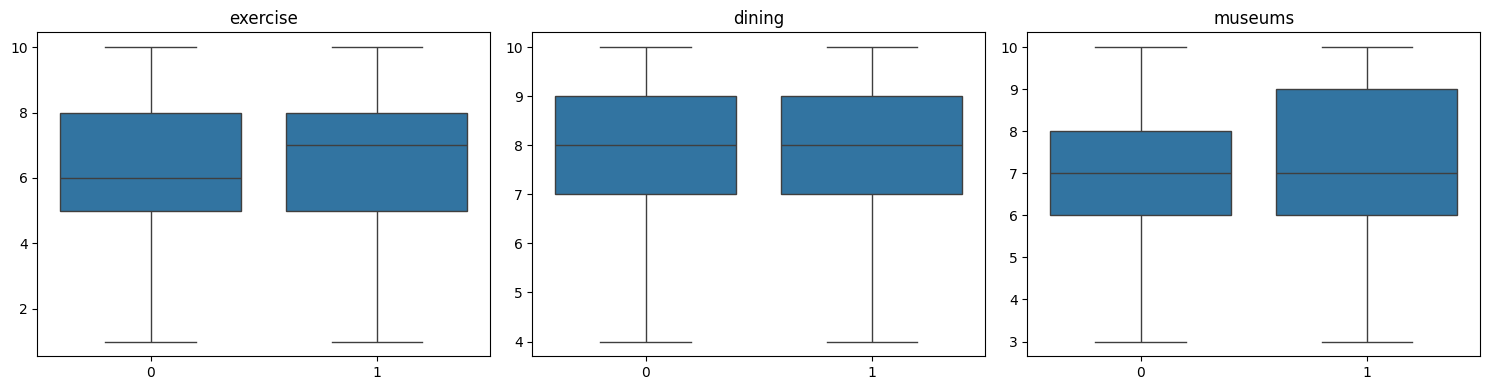

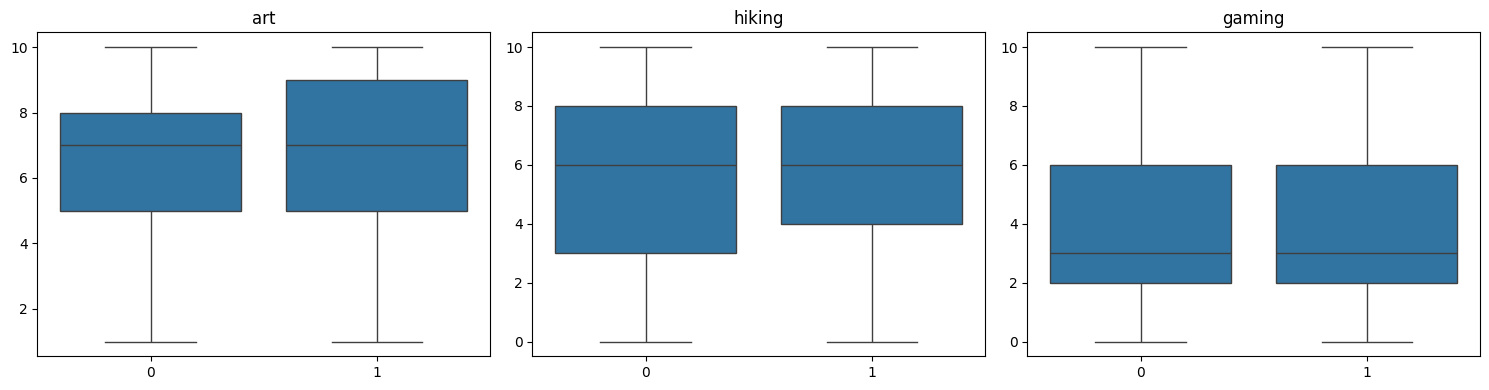

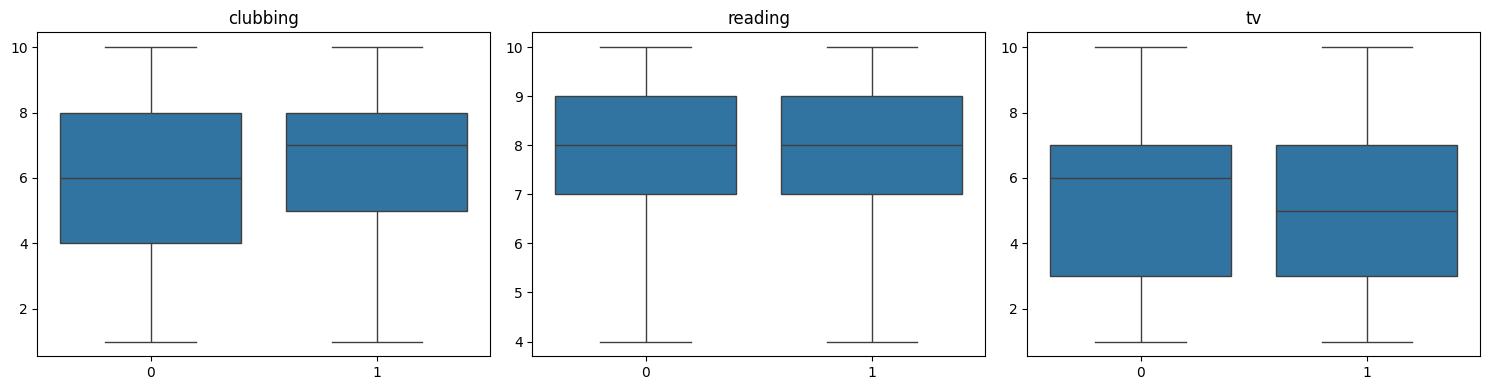

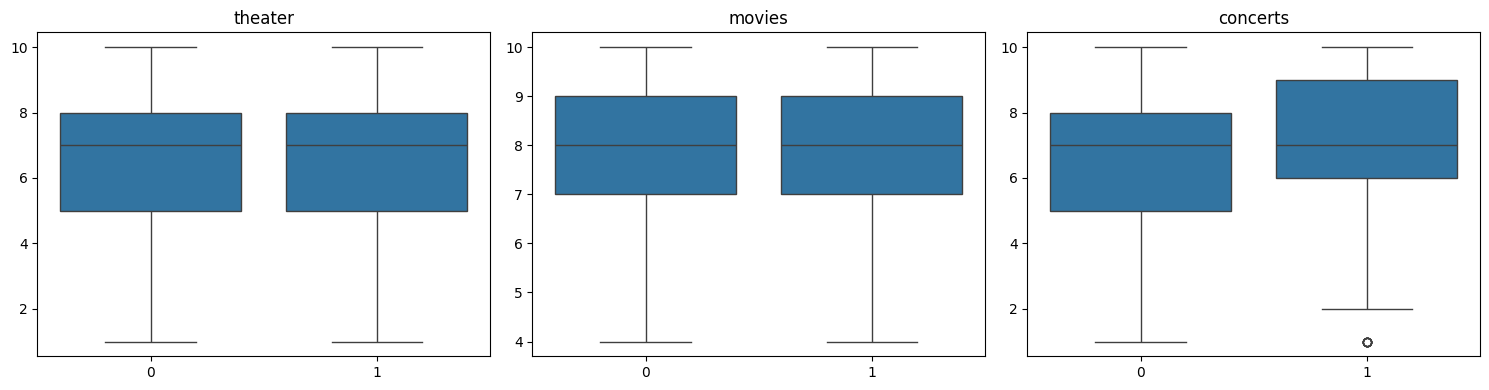

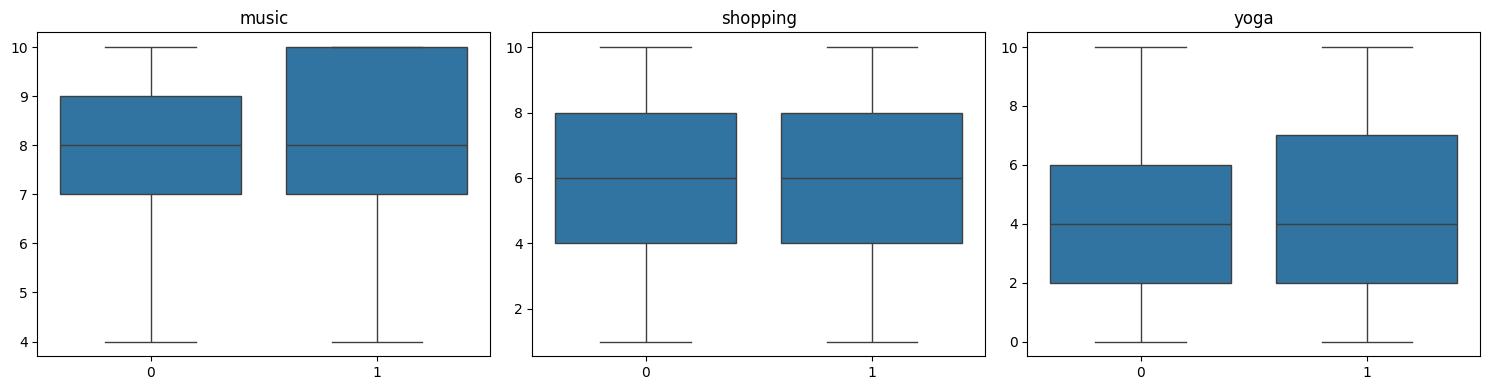

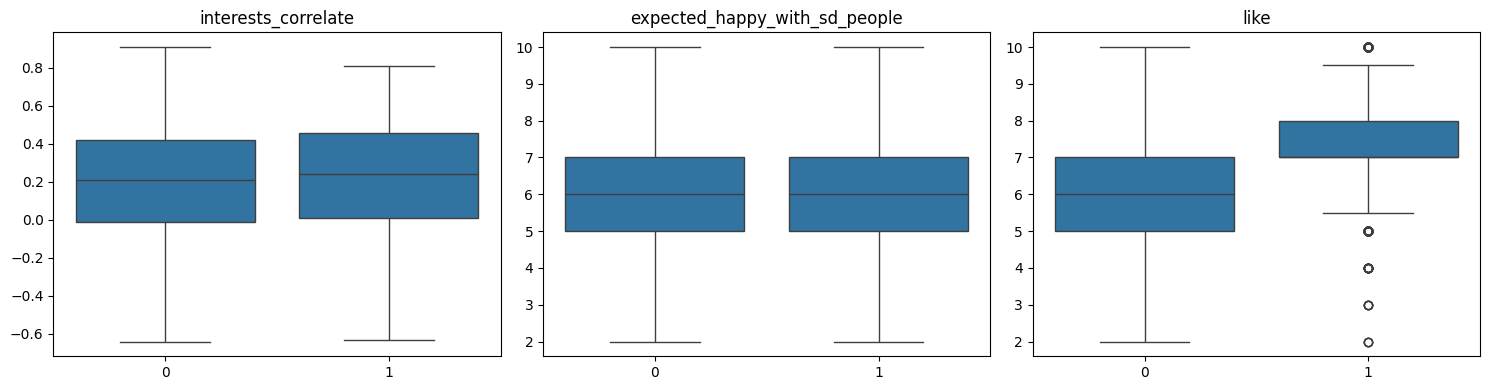

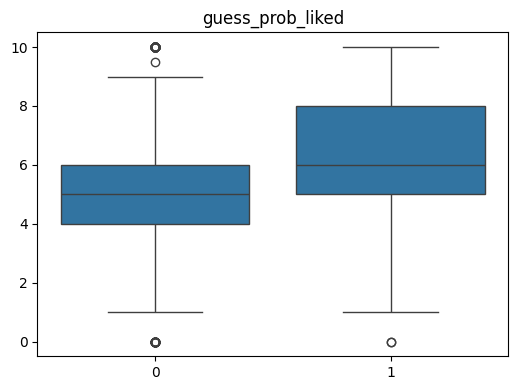

In [72]:
## Boxplots
n_per_row = 3
n_rows = math.ceil(len(numerical_cols) / n_per_row)

for r in range(n_rows):
    plt.figure(figsize=(n_per_row*5, 4))
    
    row_cols = numerical_cols[r*n_per_row : (r+1)*n_per_row]
    
    for i, col in enumerate(row_cols, start=1):
        plt.subplot(1, n_per_row, i)
        sns.boxplot(x='match', y=col, data=data)
        plt.title(col)
        plt.xlabel("")
        plt.ylabel("")
    
    plt.tight_layout()
    plt.show()


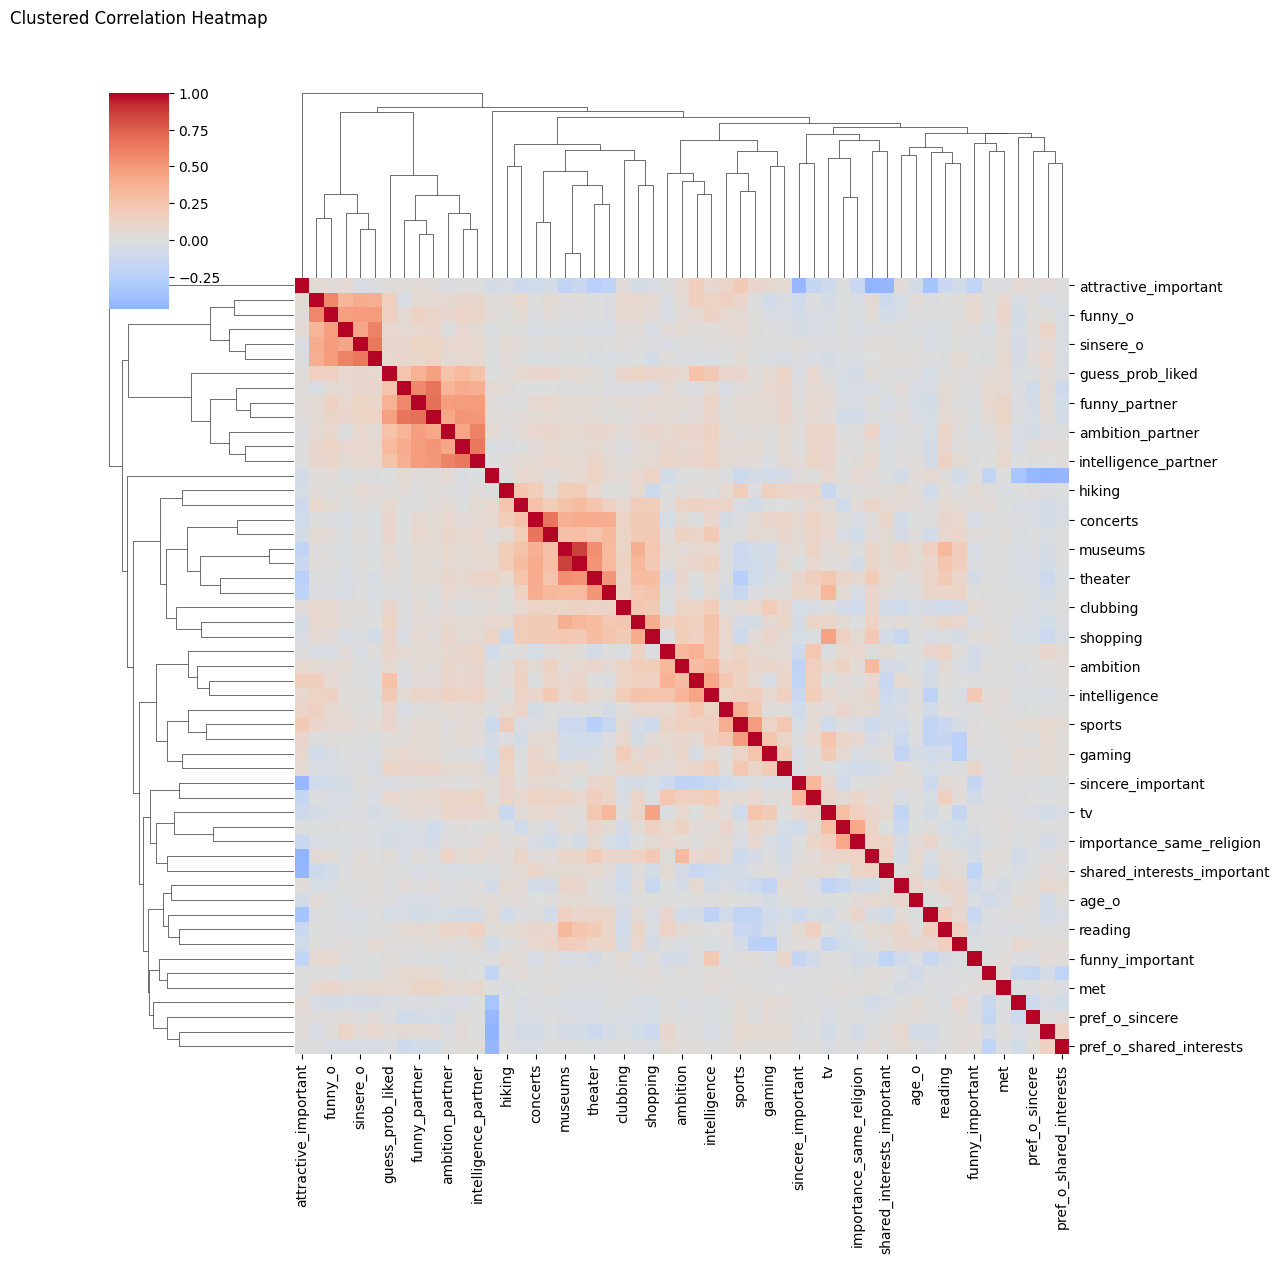

Top correlations:
museums               art                           0.858492
funny_partner         like                          0.680667
attractive_partner    like                          0.664995
concerts              music                         0.655750
sincere_partner       intelligence_partner          0.652546
                                                      ...   
pref_o_attractive     pref_o_sincere               -0.439602
attractive_important  shared_interests_important   -0.447330
pref_o_attractive     pref_o_shared_interests      -0.448064
attractive_important  ambtition_important          -0.469935
pref_o_attractive     pref_o_ambitious             -0.470378
Length: 1378, dtype: float64


In [78]:
corr_matrix = df_numeric.corr()

sns.clustermap(corr_matrix, cmap='coolwarm', center=0, figsize=(12, 12))
plt.title('Clustered Correlation Heatmap', pad=50)
plt.show()

corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  
    .stack()
    .sort_values(ascending=False)
)
print("Top correlations:")
print(corr_pairs)


In [89]:
df_numeric = data[numeric_cols]

corr_matrix = df_numeric.corr().abs()
threshold = 0.8

high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        col1 = corr_matrix.columns[i]
        col2 = corr_matrix.columns[j]
        corr_value = corr_matrix.iloc[i, j]
        if corr_value > threshold:
            high_corr_pairs.append((col1, col2, corr_value))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Variable 1', 'Variable 2', 'Correlation'])
high_corr_df = high_corr_df.sort_values(by='Correlation', ascending=False)

print("Highly correlated variable pairs (correlation > 0.80):")
print(high_corr_df)

Highly correlated variable pairs (correlation > 0.80):
  Variable 1 Variable 2  Correlation
0    museums        art     0.813278


In [92]:
data = data.drop(columns=['art'])